In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='452778eb-d85f-4567-a2ee-ae3cf613c834', project_access_token='p-f26ec291e8a83bc0680d8ee012dca78b9d825dfa')
pc = project.project_context


# Predicting Athletes' Success based on Physical Built - ETL

## Libs

In [2]:
from ibm_botocore.client import Config
import ibm_boto3

In [3]:
SEED = 42

# Numpy
import numpy as np
np.random.seed(SEED)

# Pandas
import pandas as pd

# Sklearn

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import cross_validate, learning_curve, train_test_split

# Metrics and tuning
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm

import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Stats
from scipy import stats

# Vizualization
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_ae9960ddc8814d4c8b5407d633c117e6 = 'https://s3.ap.cloud-object-storage.appdomain.cloud'
else:
    endpoint_ae9960ddc8814d4c8b5407d633c117e6 = 'https://s3.private.ap.cloud-object-storage.appdomain.cloud'

client_ae9960ddc8814d4c8b5407d633c117e6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='y-i7Ll-_fH7OmwBZU47jYLDcYfCQFgbdSFfHOig9oGAC',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_ae9960ddc8814d4c8b5407d633c117e6)

body = client_ae9960ddc8814d4c8b5407d633c117e6.get_object(Bucket='ibmadvanceddatasciencecapstone-donotdelete-pr-imkca0ueactk84',Key='ide.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,0
2,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,0
3,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",0
4,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,0


## Defining functions

In [5]:
def histograms_numeric_columns(df, numerical_columns):
    '''
    Takes df, numerical columns as list
    Returns a group of histagrams
    '''
    f = pd.melt(df, value_vars=numerical_columns) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    g = g.map(sns.distplot, 'value')
    return g

def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g

def cramers_v(x, y):
    '''
    Returns cramers_v for 2 categorical features
    '''
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def heatmap_categorical_columns_w_dependant_categorical(df, dependent_variable, columns):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of catecorical columns cramers_v with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    corrM = [cramers_v(df[dependent_variable], df[column]) for column in columns]
    corr = pd.DataFrame(corrM, index=columns, columns=[dependent_variable])
    ax = sns.heatmap(corr,
            annot=True,
            cmap='coolwarm', 
            vmin=-1,
            vmax=1,
           )
    ax.set_title("Cramer V Correlation between Variables")
    return ax

## ETL

### Data Cleansing
Drop unnecessary columns
- Name
- NOC
- Games
- Year	
- Season	
- City	
- Sport	

In [6]:
df = df_data_1.drop(columns=[
    'Name',
    'NOC',
    'Games',
    'Year',
    'Season',
    'City',
    'Sport',
])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206165 entries, 0 to 206164
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      206165 non-null  int64  
 1   Sex     206165 non-null  object 
 2   Age     206165 non-null  float64
 3   Height  206165 non-null  float64
 4   Weight  206165 non-null  float64
 5   Team    206165 non-null  object 
 6   Event   206165 non-null  object 
 7   Medal   206165 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 12.6+ MB


## Missing values
These were dealt with during initial data exploration.

## Guideline checks
## Data types
Data types of columns match their content. 

In [7]:
df['Sex'] = df['Sex'].astype('category')
df['Team'] = df['Team'].astype('category')
df['Event'] = df['Event'].astype('category')

## Ranges
Check the distribution of values in a column.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47666b51d0>]],
      dtype=object)

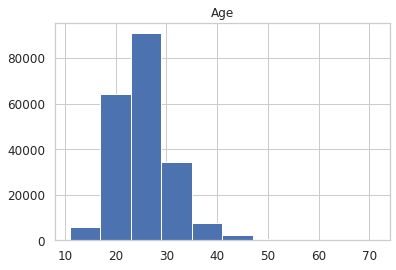

In [8]:
df.hist('Age')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47665a8c10>]],
      dtype=object)

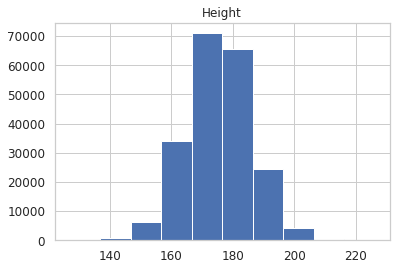

In [9]:
df.hist('Height')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f476658fbd0>]],
      dtype=object)

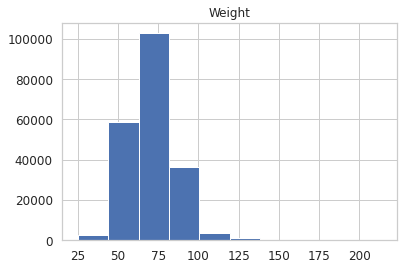

In [10]:
df.hist('Weight')

## Load data to object storage

In [11]:
project.save_data(data=df.to_csv(index=False),file_name='etl.csv',overwrite=True)

{'file_name': 'etl.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmadvanceddatasciencecapstone-donotdelete-pr-imkca0ueactk84',
 'asset_id': '33614375-c2fc-4e39-9311-caefec4f8008'}